<a href="https://colab.research.google.com/github/qmeng222/MNIST-Playground/blob/main/autoencoder/occlusion_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import numpy as np

import torch
import torch.nn as nn # build model, loss func
import torch.nn.functional as F # activation func

import copy # for making deep copies

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

In [49]:
# import dataset:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',') # np array
print(data.shape)

# don't need labels, just extract data:
data   = data[:,1:]

# normalize the data to [0 1]:
dataNorm = data / np.max(data)

# np array -> torch tensor:

dataT = torch.tensor( dataNorm ).float() # DL models typically only accept float input data

(20000, 785)


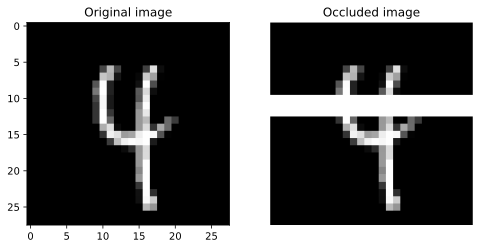

In [50]:
# reconstruct a sample image:

img = dataT[12345,:].view(28,28)

occluded = copy.deepcopy( img )
occluded[10:13,:] = 1 # add a white bar in the img for rows 10-12

fig,ax = plt.subplots(1,2,figsize=(8,5))

ax[0].imshow(img,cmap='gray')
ax[0].set_title('Original image')
# ax[0].axis('off')

ax[1].imshow(occluded,cmap='gray')
ax[1].set_title('Occluded image')
ax[1].axis('off')

plt.show()

In [51]:
# scratch:
print(occluded[12,:])
print(occluded[13,:])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.2039, 0.9961, 0.4000, 0.0000, 0.0000, 0.0000, 0.5961, 0.7294, 0.0000,
        0.0000, 0.4118, 0.2314, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])


In [52]:
def createTheMNISTAE():

  # create a class for the model:
  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,128)

      ### encoder layer
      self.enc = nn.Linear(128,50)

      ### latent layer
      self.lat = nn.Linear(50,128)

      ### decoder layer
      self.dec = nn.Linear(128,784)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.enc(x) )
      x = F.relu( self.lat(x) )
      y = torch.sigmoid( self.dec(x) ) # get the outputs in the same range as the normalized inputs
      return y

  # create the model instance
  net = aenet()

  # loss function
  lossfun = nn.MSELoss() # MSELoss for regression problem

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [53]:
def function2trainTheModel():

  # create a new model
  net,lossfun,optimizer = createTheMNISTAE()

  losses = [] # store batch losses
  batchsize  = 32
  numBatches = int(dataT.shape[0]/batchsize)

  numepochs = 5
  # loop over epochs:
  for epochi in range(numepochs):

    # get a permuted index vector (each epoch goes through all samples):
    randidx = np.random.permutation(dataT.shape[0]).astype(int)
    # np.random.permutation(): generate a random array of values between 0 and the specified size (in this case, the number of rows in dataT)
    # np.random.permutation(10) -> array([1, 7, 4, 3, 0, 9, 2, 5, 8, 6]) # random
    # the elements are stored as floats
    # astype(int): convert the random values generated by the permutation() function into integers

    # loop over training batches:
    for batchi in range(numBatches):

      samps2use = range((batchi-1)*batchsize,batchi*batchsize) # batch sectioning using indices
      X = dataT[randidx[samps2use],:] # select batch images

      # forward pass (with the ORIGINAL data)
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop (with the ORIGINAL data)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # record batch losses
      losses.append( loss.item() )

  # end epochs

  # function output
  return losses,net

3125
[0.2315581738948822, 0.22852368652820587, 0.22694210708141327, 0.2270970493555069, 0.2231139987707138, 0.22001850605010986, 0.21602924168109894, 0.2085905820131302, 0.20251713693141937, 0.19120922684669495, 0.17751993238925934, 0.1651102900505066, 0.15203022956848145, 0.13738307356834412, 0.12331458181142807, 0.11073064804077148, 0.10274200886487961, 0.09321122616529465, 0.07946176081895828, 0.0829736590385437, 0.08465708792209625, 0.08078203350305557, 0.07285330444574356, 0.07704228162765503, 0.0847083181142807, 0.08215580135583878, 0.07124198973178864, 0.07596894353628159, 0.08922348916530609, 0.07119771093130112, 0.07875292003154755, 0.07681537419557571, 0.07098467648029327, 0.07806067913770676, 0.07187464088201523, 0.07284971326589584, 0.07930455356836319, 0.07228647917509079, 0.07117246836423874, 0.0688791498541832, 0.0730414167046547, 0.06983388960361481, 0.07759438455104828, 0.07224422693252563, 0.08195934444665909, 0.06442461907863617, 0.06568008661270142, 0.07456907629966

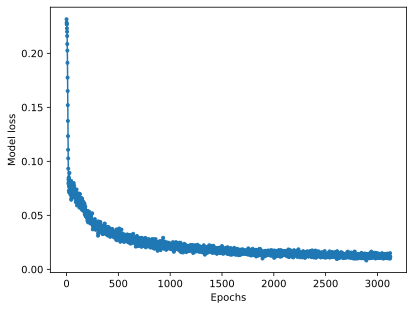

In [54]:
# train with ORIGINAL IMAGES!

losses,net = function2trainTheModel()
print(len(losses)) # len = batch size X batches = 20000/32 X 5
print(losses)
print(losses[-1])
print(f'Final loss: {losses[-1]:.4f}')

# visualize the losses
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()

torch.Size([10, 784])


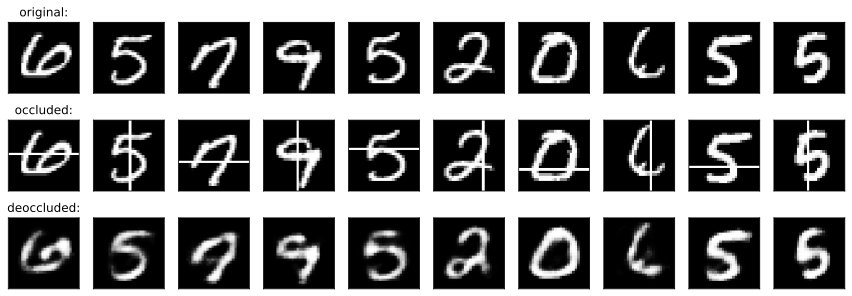

In [55]:
# test with OCCLUDED IMAGES!

# make a deep copy to add occluded bars:
X = copy.deepcopy( dataT[:10,:] ) # take the first 10 rows of the data
print(X.shape) # (10, 784)

# loop over the rows:
for i in range(X.shape[0]):
  img = X[i,:].view(28,28) # reshape (1, 784)->(28, 28)

  # occlude random rows or columns:
  startloc = np.random.choice(range(10,21)) # a single random value in the range 10-21 (inclusive), 28 pixels in total
  if i%2==0: # even -> horizontal occlusion
    img[startloc:startloc+1,:] = 1
  else:      # odd -> vertical occlusion
    img[:,startloc:startloc+1] = 1

# now run the samples through the model:
deOccluded = net(X)


# show the noisy images:
fig,axs = plt.subplots(3,10,figsize=(15,5))

for i in range(10): # 10 imgs in a row
  # 1st row: original imgs
  axs[0,i].imshow(dataT[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([]) # hide the x and y tick labels on the plot
  axs[0,0].set_title('original:')

  # 2nd row: noisy imgs
  axs[1,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  axs[1,0].set_title('occluded:')

  # 3rd row: deoccluded imgs
  axs[2,i].imshow(deOccluded[i,:].view(28,28).detach() ,cmap='gray')
  axs[2,i].set_xticks([]), axs[2,i].set_yticks([])
  axs[2,0].set_title('deoccluded:')

plt.show()

In [56]:
print(X.shape)
print(img.shape)

torch.Size([10, 784])
torch.Size([28, 28])


👆 How?
- The model squeezed these images down from 784 dimensions (input layer) to 50 dimensions (latent layer), then expanded back out.
- Train with the original images, and test with the occluded images. The occluding bars weren't part of the data set that the model was training on, which is why it would not be present in the 50-dimensional representation created by the model. In other words, the model only had access to the original data without any occluding bars, so it wasn't able to learn any patterns associated with the occluding bars in the 50-dimensional space. As a result, when the model reconstructed the image after reducing it to the 50-dimensional space, the occluding bars were no longer present in the output.

# Quantify the performance of the "de-occluder":

[[1.         0.93803989]
 [0.93803989 1.        ]]


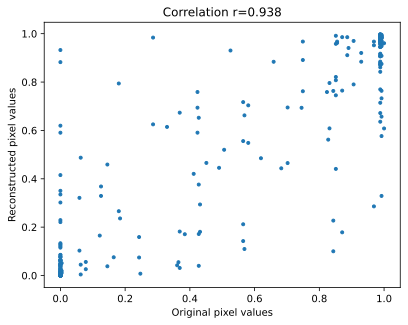

In [58]:
# quantify by correlating the all pixels in the last deOccluded img (number "5") with all pixels in its original counterpart:

inOutCorr = np.corrcoef(dataT[9,:].detach(),deOccluded[9,:].detach())
print(inOutCorr)

# and plot
plt.plot(dataT[9,:].detach(),deOccluded[9,:].detach(),'.')
plt.xlabel('Original pixel values')
plt.ylabel('Reconstructed pixel values')
plt.title(f'Correlation r={ inOutCorr[0,1] :.3f}')
plt.show()

👆 Interpretations:
- The correlation is strong (close to 1).
- However, it turns out that this correlation coefficient is a little bit difficult to interpret. That's because there's lots of zeros in the matrices.
- It's not really fair to to include all the zeros into this correlation that inflates the correlation coefficient.

torch.Size([784]) torch.Size([784])
torch.Size([784])


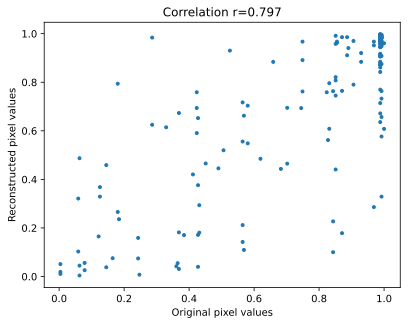

In [62]:
# rerun wo/ the zero-valued pixels:

orig  = dataT[9,:].detach() # select an image from the original
recon = deOccluded[9,:].detach() # select an image from the deoccluded
print(orig.shape, recon.shape)

# boolean vector that indicates pixels>0 (with some tolerance)
tol = 1e-4 # a very small number
nonzeropixels = (orig>tol) & (recon>tol)
print(nonzeropixels.shape)

# now re-compute the correlation for those non zero pixels:
inOutCorr = np.corrcoef(orig[nonzeropixels],recon[nonzeropixels])

# redraw the previous plot
plt.plot(orig[nonzeropixels],recon[nonzeropixels],'.')
plt.xlabel('Original pixel values')
plt.ylabel('Reconstructed pixel values')
plt.title(f'Correlation r={ inOutCorr[0,1] :.3f}')
plt.show()

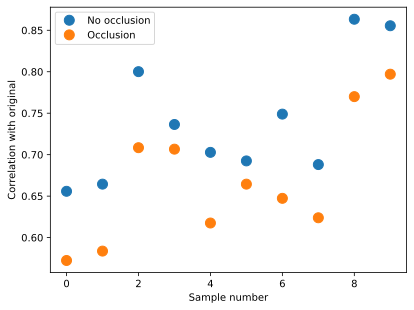

In [63]:
# get data with no occlusion:
noOcclusion = net(dataT[:10,:])

# compare deOccluded-original to noOcclusion-original correlation:
r = np.zeros((10,2))
for i in range(deOccluded.shape[0]):

  # pixel selection (note: tolerance defined in previous cell)
  nonzeropixels = (dataT[i,:]>tol) & (noOcclusion[i,:]>tol) & (deOccluded[i,:]>tol)

  # now compute the correlations
  r[i,0] = np.corrcoef(dataT[i,nonzeropixels].detach(),noOcclusion[i,nonzeropixels].detach())[0,1]
  r[i,1] = np.corrcoef(dataT[i,nonzeropixels].detach(),deOccluded[i,nonzeropixels].detach())[0,1]

# plot the correlation coefficients
plt.plot(r,'o',markersize=10)
plt.legend(['No occlusion','Occlusion'])
plt.xlabel('Sample number')
plt.ylabel('Correlation with original')
plt.show()

👆 Interpretation:
The blue dots are all higher than the orange dots, which means adding occluding bar does reduce the accuracy of the autoencoder matched to the original data.